In [185]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import datetime as dt
import seaborn as sb
sb.set()

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from itertools import product
from tqdm import tqdm_notebook
from arch import arch_model

import warnings
warnings.filterwarnings('ignore')

In [186]:
train = pd.read_csv("../AAPLTrain.csv",parse_dates=['Date'],index_col=['Date'])
test = pd.read_csv("../AAPLTest.csv",parse_dates=['Date'],index_col=['Date'])

In [187]:
train = train.loc[lambda x : x.index > dt.datetime(2012,12,31)]
df = pd.concat([train,test])

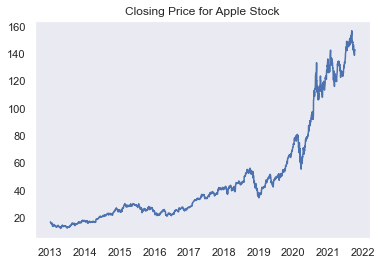

In [188]:
plt.plot(df.index,df['Adj Close'])
plt.title("Closing Price for Apple Stock")
plt.grid(False)
plt.show()

In [189]:
def plot_moving_average(series,window,plot_intervals=False,scale=1.96):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(17,8))
    plt.title('Moving Average \n Window size = {}'.format(window))
    plt.plot(rolling_mean,'g',label="Rolling Mean trend")

    if plot_intervals:
        mae = mean_absolute_error(series[window:],rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--',label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

        plt.plot(series[window:],label='Actual values')
        plt.legend(loc='best')
        plt.grid(True)

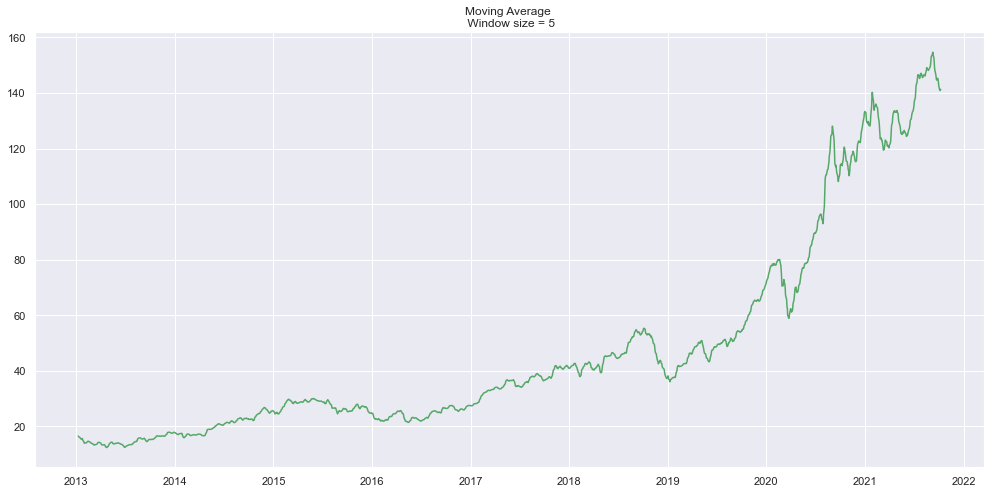

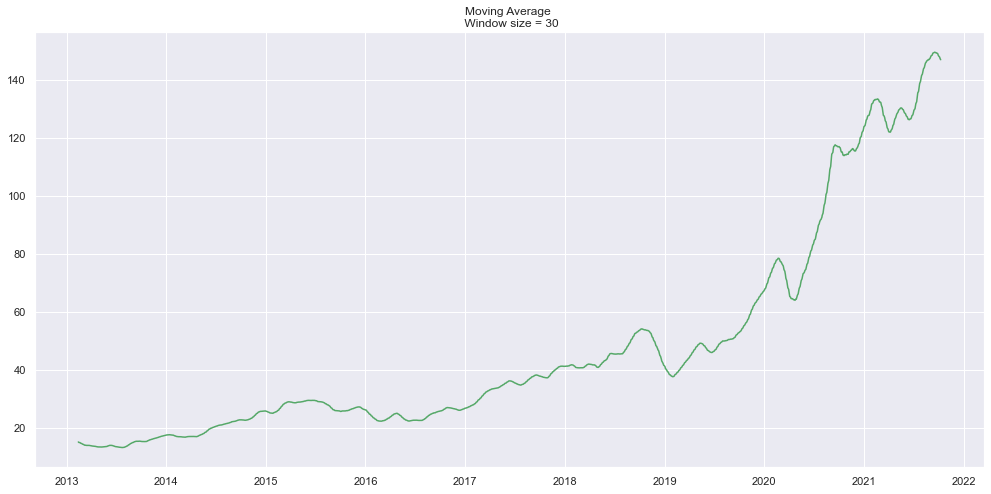

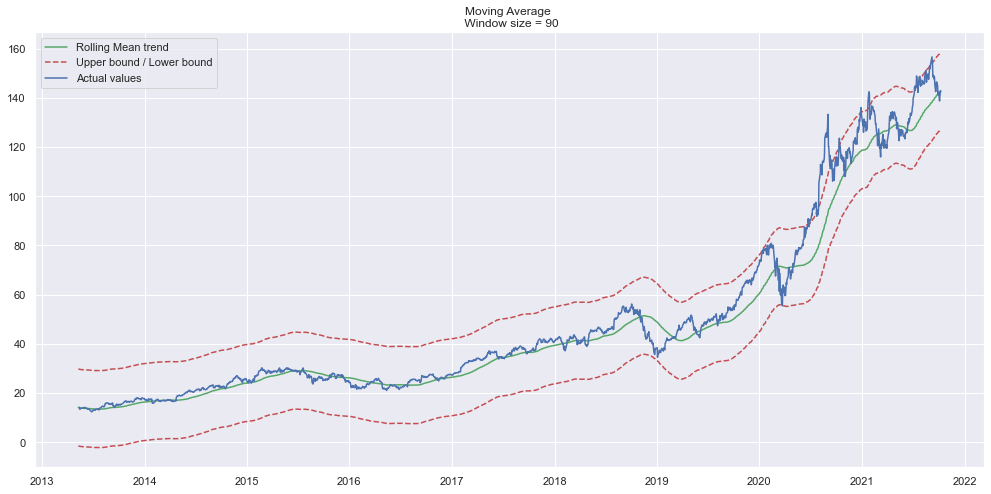

In [190]:
plot_moving_average(df['Adj Close'],5)

plot_moving_average(df['Adj Close'],30)

plot_moving_average(df['Adj Close'],90,plot_intervals=True)

In [191]:
def tsplot(y, lags=None, figsize=(12,7), style='bmh'):

    if not isinstance(y,pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout,(1,1))

        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Anaysis Plot \n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y,lags=lags,ax=acf_ax)
        smt.graphics.plot_pacf(y,lags=lags,ax=pacf_ax)
        plt.tight_layout()

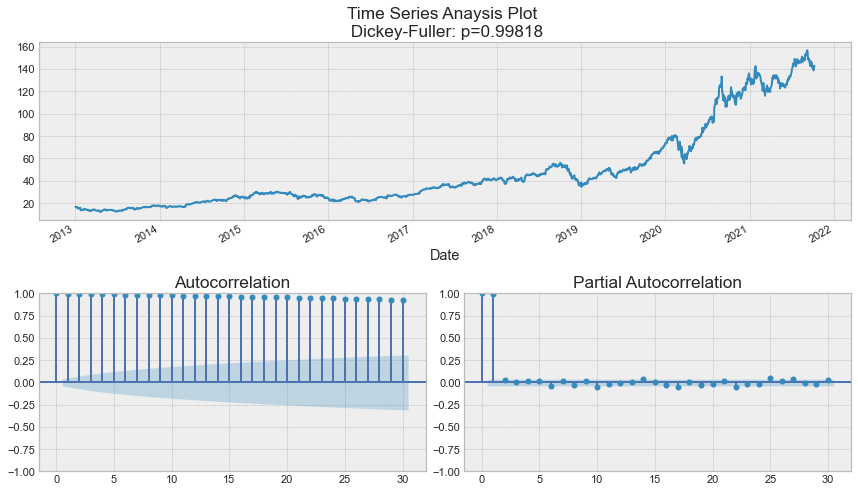

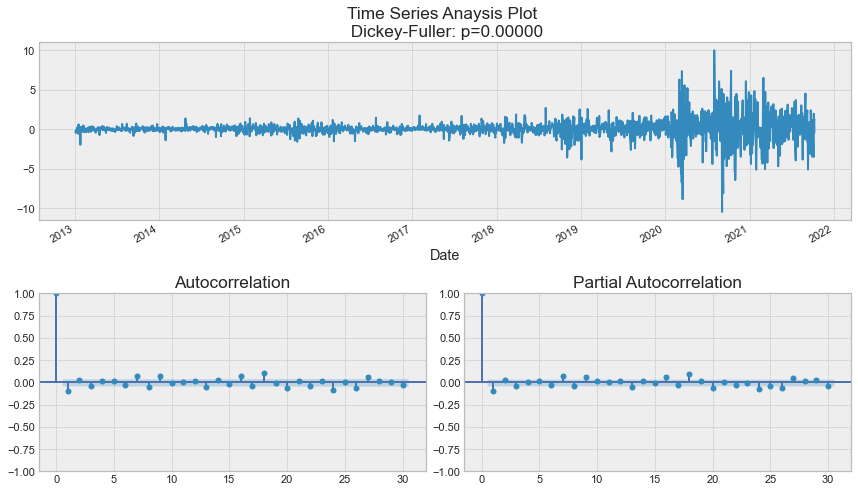

In [192]:
tsplot(df['Adj Close'],lags=30)

data_diff = df['Adj Close'] - df['Adj Close'].shift(1)

tsplot(data_diff[1:],lags=30)

In [193]:
ps = range(0,2)
d = 1
qs = range(0,2)
Ps = range(0,2)
D = 1
Qs = range(0,2)
s = 5

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

def optimize_ARIMA(parameters_list,d,D,s):
    results = []
    best_aic = float('inf')
    for param in tqdm_notebook(parameters_list):
        model = ARIMA(data_diff,order=(param[0],d,param[1]),seasonal_order=(param[2],D,param[3],s)).fit()

        aic = model.aic

        if aic < best_aic:
            best_aic = aic
        results.append([param, model.aic])

    result_table = pd.DataFrame(results, columns=['parameters','aic'])
    result_table = result_table.sort_values(by='aic',ascending=True).reset_index(drop=True)
    return result_table

In [194]:
result_table = optimize_ARIMA(parameters_list,d,D,s)
p,q,P,Q = result_table.parameters[0]
best_model = ARIMA(df['Adj Close'],order=(p,d,q),seasonal_order=(P,D,Q,s)).fit()
arima_pred = best_model.predict(start=test.index[0], end=test.index[-1])

  0%|          | 0/16 [00:00<?, ?it/s]

Date
2021-09-09    155.277130
2021-09-10    153.923388
2021-09-13    149.137449
2021-09-14    149.031016
2021-09-15    148.118350
2021-09-16    148.400570
2021-09-17    148.640235
2021-09-20    146.005595
2021-09-21    142.861557
2021-09-22    143.115148
2021-09-23    145.197489
2021-09-24    146.563353
2021-09-27    146.611150
2021-09-28    145.215693
2021-09-29    142.012147
2021-09-30    142.199482
2021-10-01    141.465001
2021-10-04    142.168681
2021-10-05    139.227421
2021-10-06    140.616813
2021-10-07    141.572536
2021-10-08    142.935096
Name: Average, dtype: float64


[]

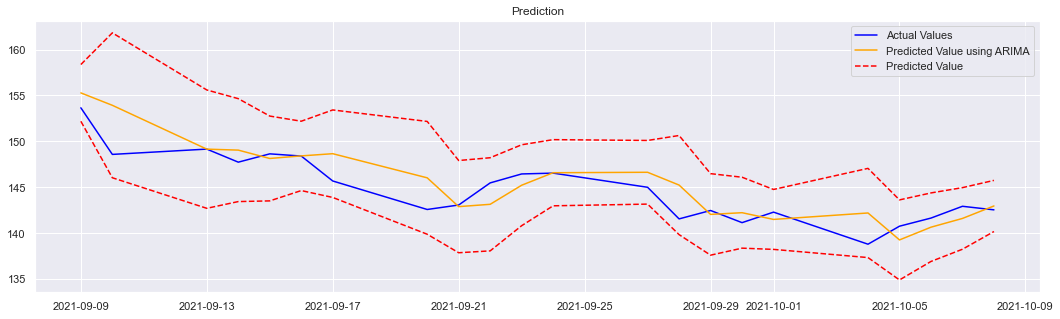

In [199]:
resid = best_model.resid.dropna()
model = arch_model(resid)
res = model.fit(disp='off',last_obs=test.index[1])
forecast = res.forecast()
pred_G = forecast.residual_variance['h.1'].dropna()
test['Upper'] = arima_pred.values + pred_G.values
test['Lower'] = arima_pred.values - pred_G.values
print(test['Average'])
fig = plt.figure(figsize=(18,5))
plt.plot(test['Adj Close'], color="blue",label="Actual Values")
plt.plot(arima_pred, color="orange",label="Predicted Value using ARIMA")
plt.plot(test['Upper'],color="red",linestyle="--", label="Predicted Value")
plt.plot(test['Lower'],color="red",linestyle="--")
plt.title("Prediction")
plt.legend()
plt.plot()